## 1. Import Python Libraries

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import user_agents

%matplotlib inline
sns.set_style('whitegrid')

## 2. Connect Database

In [2]:
conn = psycopg2.connect("host=127.0.0.1 dbname=sparkifydb user=student password=student")
cur = conn.cursor()

## 3. General Statistics

In [3]:
def get_total(cur, tables):   
    totals = dict()
    for table in tables:
        query = "SELECT count(*) FROM %s;" % table
        cur.execute(query)
        res = cur.fetchone()
        totals[table] = res[0]
    return totals

In [4]:
tables = ['songplays', 'users', 'artists', 'songs']
totals = get_total(cur, tables)
for k, v in totals.items():
    print("Total {} = {}".format(k, v))

Total songplays = 6820
Total users = 96
Total artists = 69
Total songs = 71


##### Display duplicates in songplays if it exists

In [5]:
query="""
SELECT start_time, user_id, level, song_id, artist_id, session_id, location, user_agent
FROM songplays
GROUP BY start_time, user_id, level, song_id, artist_id, session_id, location, user_agent
HAVING count(*) > 1;
"""
cur.execute(query)
res = cur.fetchall()
if res:
    df = pd.DataFrame(res)
    display(df)

## 4. Analyses

### 4.1. Functions to plot

In [6]:
def bar_plot(df, x, y, ix, iy, ax, **kwargs):
    sns.barplot(data=df, x=x, y=y, ax=ax);
    for p in ax.patches:
        ax.annotate('{}'.format(round(p.get_height())), (p.get_x() + ix, p.get_height() + iy))
    ax.set(**kwargs);

def pie_plot(df, x, y, ax, **kwargs):
    ax.pie(x=df[y], labels=df[x],
        autopct = "%.1f%%", explode = [0.05] * df.shape[0], pctdistance = 0.5
    );
    ax.set(**kwargs);

def plot_bar_pie_graphs(df, x, y, ix, iy, kwargs=[{}, {}], figsize=(16,8)):
    fig, axes = plt.subplots(1, 2, figsize = figsize)
    bar_plot(df, x, y, ix, iy, axes[0], **kwargs[0])
    pie_plot(df, x, y, axes[1], **kwargs[1])

def bar_plot_horizontal(df, x, y, ix, iy, ax, **kwargs):
    df[y] = df[y].astype(str)
    sns.barplot(data=df, x=x, y=y, ax=ax);
    for p in ax.patches:
        ax.annotate('{}'.format(round(p.get_width())), (p.get_width() + ix, p.get_y() + iy))
    ax.set(**kwargs);

### 4.2. Analyses on user level

##### Q1. Which user level is more active on Sparkify app?

In [7]:
query="""
SELECT level, count(songplay_id)
FROM songplays
GROUP BY level;
"""
cur.execute(query)
res = cur.fetchall()
df_level = pd.DataFrame(res)
df_level.columns = ['level', 'plays']
df_level.head()

,level,plays
0,free,1229
1,paid,5591


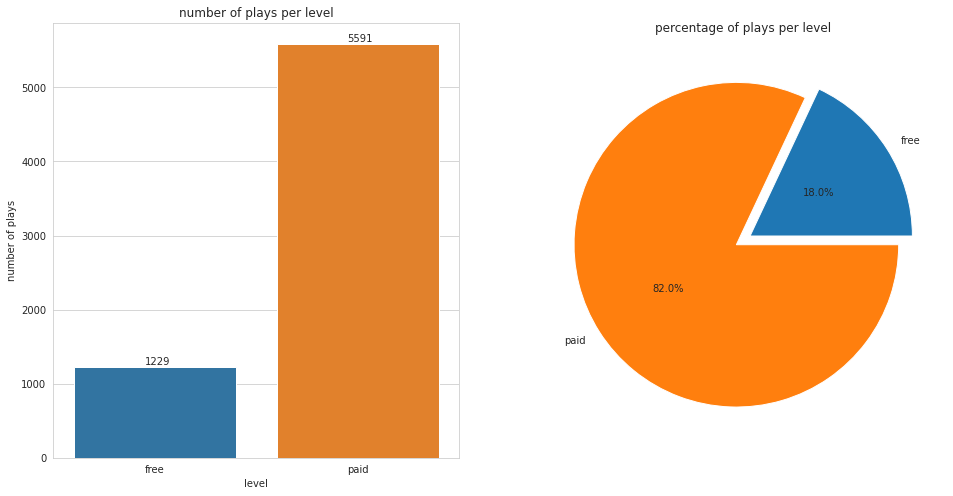

In [8]:
kwargs = [
    {'ylabel':'number of plays', 'title':'number of plays per level'},
    {'title':'percentage of plays per level'}
]
plot_bar_pie_graphs(df_level, 'level', 'plays', ix=0.35, iy=30, kwargs=kwargs)
plt.savefig('images/plays_per_level.png')

##### Q2. What is the rate of user levels?

In [9]:
query="""
SELECT level, count(user_id)
FROM users
GROUP BY level;
"""
cur.execute(query)
res = cur.fetchall()
df_user = pd.DataFrame(res)
df_user.columns = ['level', 'users']
df_user.head()

,level,users
0,free,81
1,paid,15


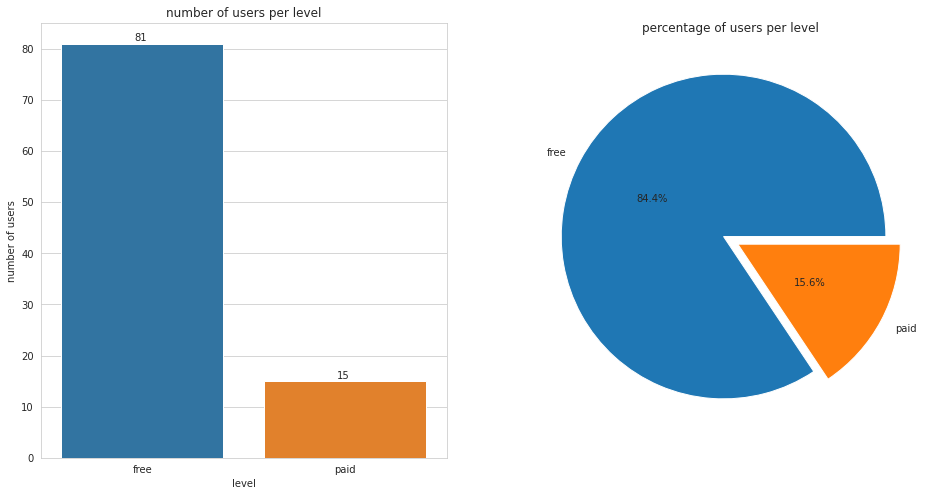

In [10]:
kwargs = [
    {'ylabel':'number of users', 'title':'number of users per level'},
    {'title':'percentage of users per level'}
]
plot_bar_pie_graphs(df_user, 'level', 'users', ix=0.36, iy=0.5, kwargs=kwargs)
plt.savefig('images/users_per_level.png')

### 4.3. Analyses on user agent

In [11]:
query="""
SELECT user_agent, count(songplay_id)
FROM songplays
GROUP BY user_agent;
"""
cur.execute(query)
res = cur.fetchall()
df_user_agent = pd.DataFrame(res)
df_user_agent.columns = ['user_agent', 'plays']

ugs = [user_agents.parse(i) for i in df_user_agent['user_agent']]
df_user_agent['browser'] = [ug.browser.family for ug in ugs]
df_user_agent['os'] = [ug.os.family for ug in ugs]
df_user_agent['device'] = [ug.device.family for ug in ugs]
df_user_agent.head()

,user_agent,plays,browser,os,device
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",111,Chrome,Mac OS X,Mac
1,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",427,Chrome,Windows,Other
2,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,30,Firefox,Windows,Other
3,Mozilla/5.0 (Windows NT 6.1; rv:31.0) Gecko/20...,26,Firefox,Windows,Other
4,"""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",577,Chromium,Ubuntu,Other


##### Q3. Which browsers are used to access Sparkify app?

In [12]:
df_browser = df_user_agent[['browser', 'plays']].groupby(['browser']).sum().reset_index()
df_browser.head()

,browser,plays
0,Chrome,3319
1,Chromium,577
2,Firefox,1589
3,IE,28
4,Mobile Safari,239


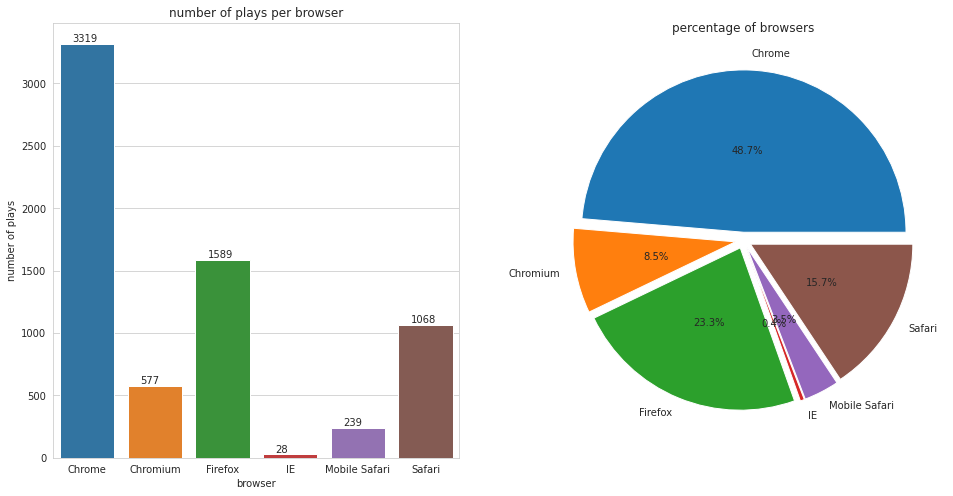

In [13]:
kwargs = [
    {'ylabel':'number of plays', 'title':'number of plays per browser'},
    {'title':'percentage of browsers'}
]
plot_bar_pie_graphs(df_browser, 'browser', 'plays', ix=0.18, iy=15, kwargs=kwargs)
plt.savefig('images/browser.png')

##### Q4. Which OS are used to access Sparkify app?

In [14]:
df_os = df_user_agent[['os', 'plays']].groupby(['os']).sum().reset_index()
df_os.head()

,os,plays
0,Linux,576
1,Mac OS X,3000
2,Ubuntu,577
3,Windows,2428
4,iOS,239


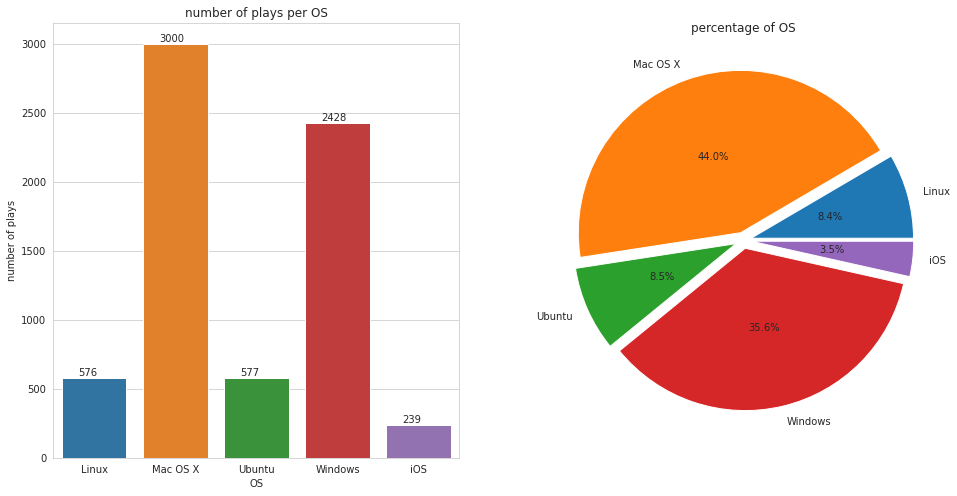

In [15]:
kwargs = [
    {'ylabel':'number of plays', 'title':'number of plays per OS', 'xlabel':'OS'},
    {'title':'percentage of OS'}
]
plot_bar_pie_graphs(df_os, 'os', 'plays', ix=0.2, iy=15, kwargs=kwargs)
plt.savefig('images/os.png')

##### Q5. Which devices are used to access Sparkify app?

In [16]:
df_device = df_user_agent[['device', 'plays']].groupby(['device']).sum().reset_index()
df_device.head()

,device,plays
0,Mac,3000
1,Other,3581
2,iPhone,239


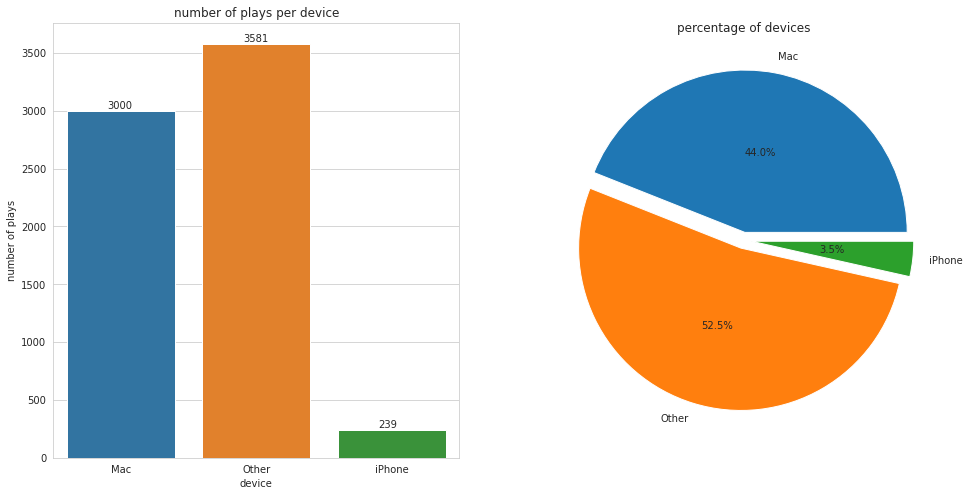

In [17]:
kwargs = [
    {'ylabel':'number of plays', 'title':'number of plays per device'},
    {'title':'percentage of devices'}
]
plot_bar_pie_graphs(df_device, 'device', 'plays', ix=0.3, iy=20, kwargs=kwargs)
plt.savefig('images/device.png')

### 4.4. Analyses on start time

##### Q6. What is the rate of using Sparkify app over weeks?

In [18]:
query="""
SELECT week, count(songplay_id)
FROM songplays
JOIN time ON songplays.start_time = time.start_time
GROUP BY week
ORDER BY week;
"""
cur.execute(query)
res = cur.fetchall()
df_week = pd.DataFrame(res)
df_week.columns = ['week', 'plays']
df_week.head()

,week,plays
0,44,410
1,45,1257
2,46,1958
3,47,1711
4,48,1484


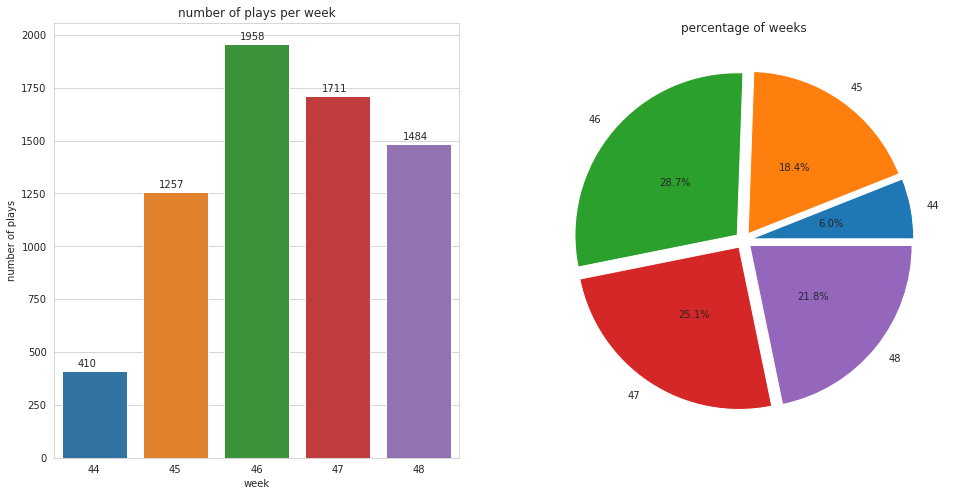

In [19]:
kwargs = [
    {'ylabel':'number of plays', 'title':'number of plays per week'},
    {'title':'percentage of weeks'}
]
plot_bar_pie_graphs(df_week, 'week', 'plays', ix=0.2, iy=20, kwargs=kwargs)
plt.savefig('images/week.png')

### 4.5. Analyses on location

##### Q7. What are top users, top regions using Sparkify app?

In [20]:
query="""
SELECT user_id, count(songplay_id) AS plays
FROM songplays
GROUP BY user_id
ORDER BY plays DESC
LIMIT 10;
"""
cur.execute(query)
res = cur.fetchall()
df_user = pd.DataFrame(res)
df_user.columns = ['user', 'plays']
df_user.head()

,user,plays
0,49,689
1,80,665
2,97,557
3,15,463
4,44,397


In [21]:
query="""
SELECT REVERSE(TRIM(SPLIT_PART(REVERSE(location), ',', 1))) AS region, count(songplay_id) AS plays
FROM songplays
GROUP BY region
ORDER BY plays DESC
LIMIT 10;
"""
cur.execute(query)
res = cur.fetchall()
df_region = pd.DataFrame(res)
df_region.columns = ['region', 'plays']
df_region.head()

,region,plays
0,CA,1572
1,ME,665
2,MI,636
3,IL-IN-WI,475
4,GA,456


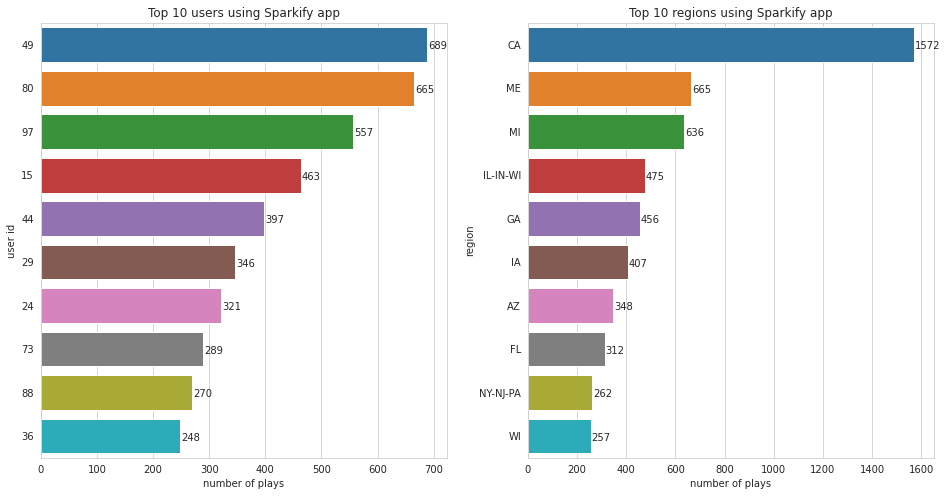

In [22]:
kwargs = [
    {'xlabel':'number of plays', 'title':'Top 10 users using Sparkify app', 'ylabel': 'user id'},
    {'xlabel':'number of plays', 'title':'Top 10 regions using Sparkify app'}
]
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
bar_plot_horizontal(df_user, 'plays', 'user', ix=2, iy=0.5, ax=axes[0], **kwargs[0])
bar_plot_horizontal(df_region, 'plays', 'region', ix=2, iy=0.5, ax=axes[1], **kwargs[1])
plt.savefig('images/top_users_regions.png')

In [23]:
cur.close()
conn.close()